In [2]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import scipy as sp
import seaborn as sns
#from plotting import annotate_cor
#from matplotlib.lines import Line2D
#from functools import partial
#from scipy import stats


sns.set(style='ticks', context='paper',
        rc={'font.size': 6, 
            'axes.titlesize': 7,
            'axes.labelsize': 7,
            'axes.labelpad': 2,
            'xtick.labelsize': 5,
            'ytick.labelsize': 5,
            'legend.title_fontsize' : 5.5,
            'legend.fontsize' : 5.5,
            'legend.markerscale': 0.5,
            'axes.spines.top': False,
            'axes.spines.right': False,
            'axes.linewidth': 0.4,
            'xtick.major.width': 0.4,
            'ytick.major.width': 0.4,
            'xtick.major.size': 2.5,
            'ytick.major.size': 2.5,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.minor.width': 0.2,
            'ytick.minor.width': 0.2,
            'figure.constrained_layout.use': True,
            'figure.dpi': 200})

id_columns = ['architecture', 'task', 'kind', 'source', 'layer']


#data = pd.merge(pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigspectra_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'), pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigmetrics_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),on=id_columns)


In [12]:

#f = 'nPCs50'
reg = 'pls'
#de = pd.read_csv(f'../../results_marcc/nPCs/encoding_{f}|benchmark:dicarlo.MajajHong2015.IT.public-{reg}|pooling:none.csv')
#pc_string = de['source']
#for pc

enc_files = ['nPCs25', 'nPCs50', 'nPCs100', 'nPCs500', 'nPCs1000']
df = pd.DataFrame()
for f in enc_files:
    de = pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/nPCs/encoding_{f}_SVD|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv')
    df = df.append(de)

df.to_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/nPCs/encoding_allnPCs_SVD|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv', index=False)

/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


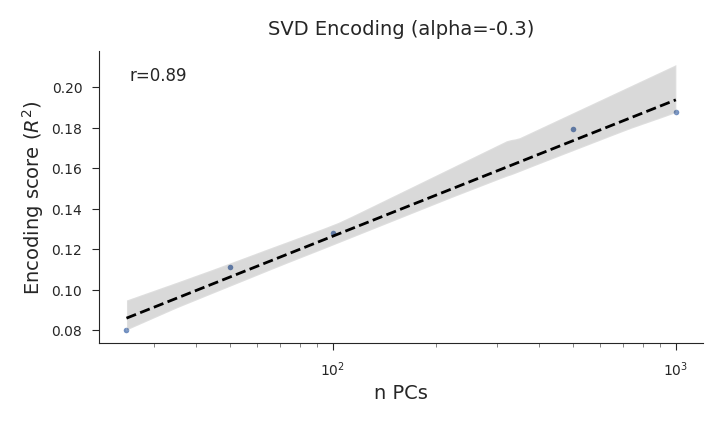

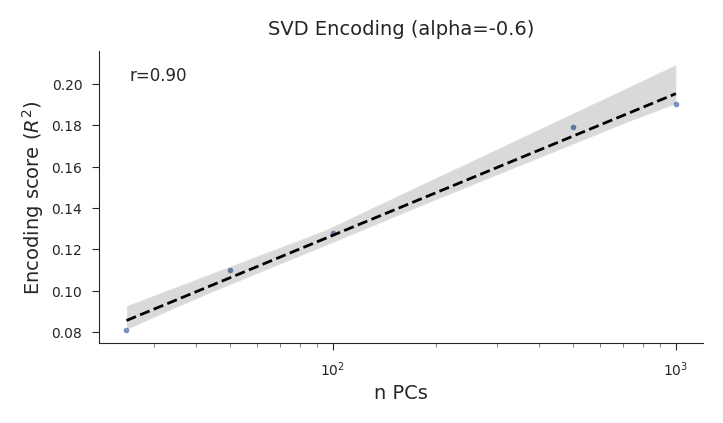

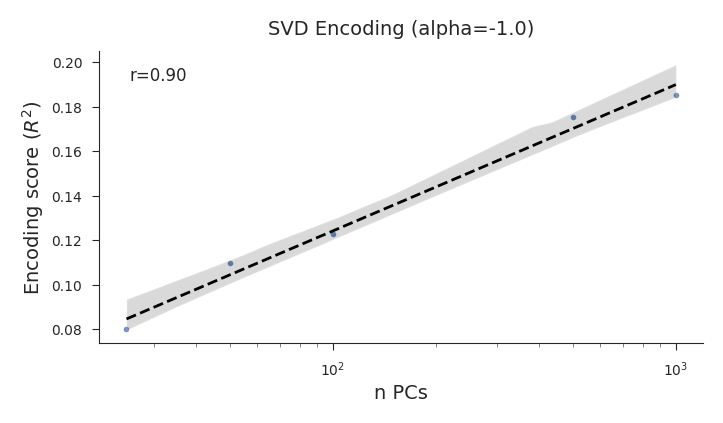

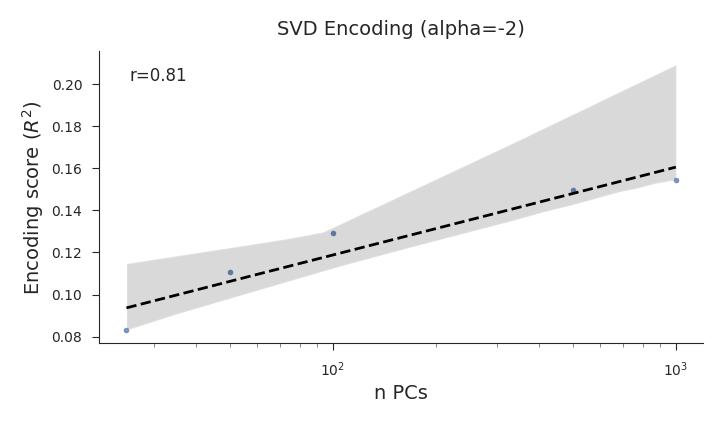

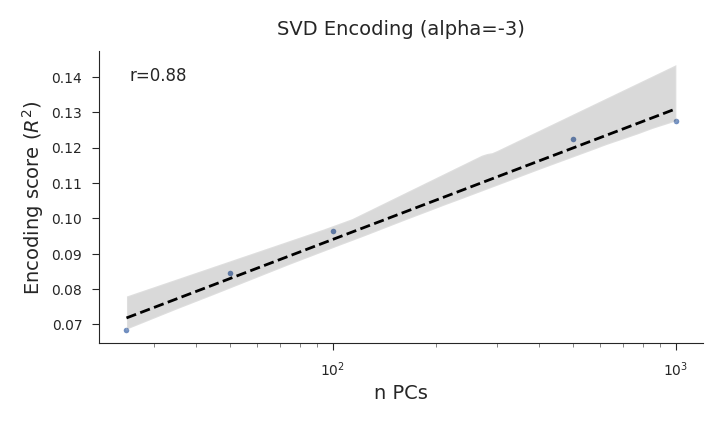

In [15]:
#Encoding model
# - **plot encoding score vs nPCs

enc_files = ['allnPCs']
#enc_files = ['nPCs25', 'nPCs50', 'nPCs100', 'nPCs500', 'nPCs1000']
reg = 'pls'
#id_columns = ['architecture', 'task', 'kind', 'layer'] #spec source='pcs_none', enc source = 'pcs_1000'


spectra = False
encoding = True

#eigenspectra

if spectra:
    spec_file = 'nPCsEig'
    spec_data = 'imagenet'
    
    pooling = ['max', 'none']
    for p in pooling:
        t = f'SVD (pooling={p})'

        dm = pd.read_csv(f'../../results_marcc/nPCs/eigmetrics_{spec_file}|dataset{spec_data}|pooling:{p}|grayscale:False.csv')
        ds = pd.read_csv(f'../../results_marcc/nPCs/eigspectra_{spec_file}|dataset:{spec_data}|pooling:{p}|grayscale:False.csv')
        data = pd.merge(dm, ds, on=id_columns)
        data['id'] = data[id_columns].sum(axis='columns')
        data = data[ (data['layer']=='c2') ]
        
    # Remove outlier low-variance points at the final PCs
        def is_outlier(i):
            i = np.log(i)
            cutoff = 0.95 * i.iloc[-1]
            return i > cutoff
        outlier = data.groupby(id_columns)['n'].transform(is_outlier)
        data = data[~outlier]

    # Set y-intercept to 1
        def get_scaled_var(x):
            i, y = x['n'].values, x['variance'].values
            i, y = np.log(i), np.log(y)
            intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
            intercept = np.exp(intercept)
            return x['variance'] / intercept
        scaled_var = data.groupby(id_columns).apply(get_scaled_var)
        scaled_var = scaled_var.reset_index(id_columns, drop=True)
        data['scaled_variance'] = scaled_var

    # Log(ED)
        data['log_ed'] = np.log10(data['effective dimensionality'])

        fig, ax = plt.subplots(figsize=(3, 3))
        sns.lineplot(data=data, x='n', y='scaled_variance', hue='kind',
                    units='id', alpha=0.2, estimator=None,
                    palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
        ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
        ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title=t)
        ax.set_ylim(bottom=10**(-9), top=10**4)
        ax.legend(title='Weights Powerlaw Slope')
        #ax.legend(title=r'$\log{(ED)}$')
        #plt.show()
        
        
#encoding score
if encoding:
    p = 'none'
    
    for f in enc_files:
        
        #n_pcs = ''.join(i for i in f if i.isdigit())
    
        #dm = pd.read_csv(f'../../results_marcc/nPCs/eigmetrics_{spec_file}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
        data = pd.read_csv(f'../../results_marcc/nPCs/encoding_{f}_SVD|benchmark:dicarlo.MajajHong2015.IT.public-{reg}|pooling:none.csv')
        data = data[ (data['layer']=='c2') ]
        data['source'] = pd.to_numeric(data['source'].str.split('_').str[1])
        data['id'] = data[id_columns].sum(axis='columns')
        
        #alphas = [-0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0, -1.2, -1.4, -1.6, -1.8, -2, -2.2, -2.4, -2.6, -2.8, -3]
        alphas = [-0.3, -0.6, -1.0, -2, -3]
        for a in alphas:
            data_alpha = data[ (data['kind']==f'a_{a}')]
            t = f'SVD Encoding (alpha={a})'
            
            r, p_val = sp.stats.pearsonr(data_alpha['source'], data_alpha['score'])

            fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
            sns.regplot(data=data_alpha, x='source', y='score',
                        logx=True,
                        scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
                        line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                        ax=ax)
            ax.set(xlabel='n PCs', ylabel=r'Encoding score ($R^2$)', xscale='log', title=t)
            ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
            #ax.set_ylim(bottom=0, top=0.65)
            #ax.set_xlim(0.8, 270)

plt.show()

/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:73: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


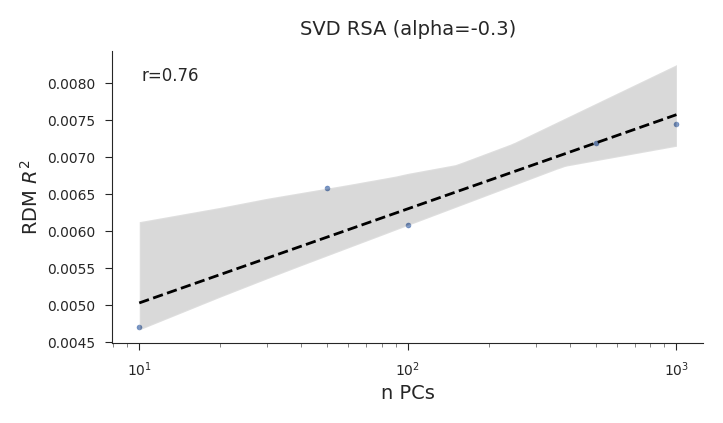

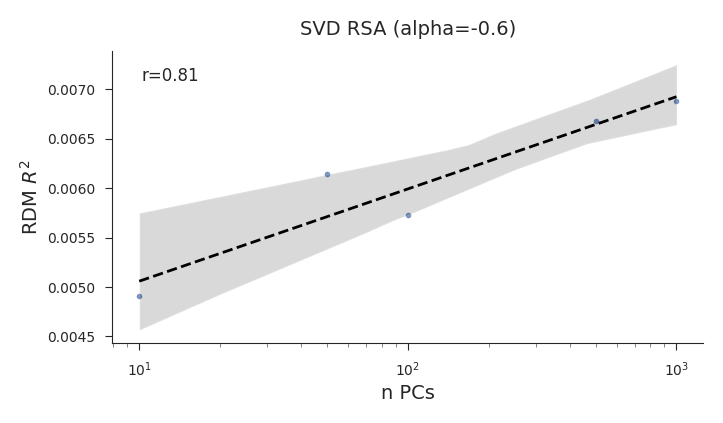

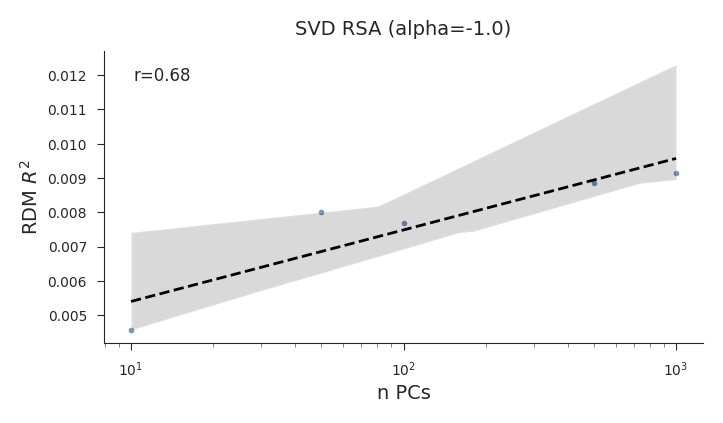

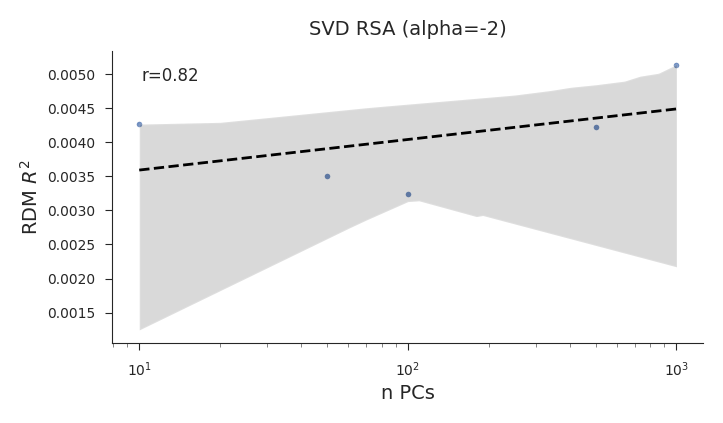

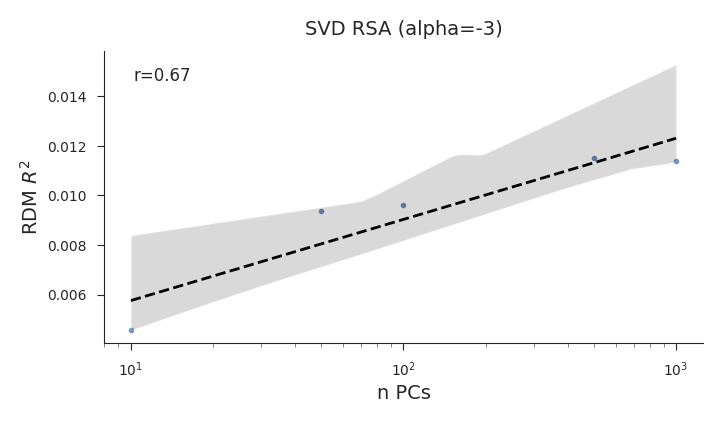

In [16]:
#RSA
# - **plot rsa results vs nPCs

files = ['allnPCs']

#id_columns = ['architecture', 'task', 'kind', 'layer'] #spec source='pcs_none', enc source = 'pcs_1000'


spectra = False
encoding = True


#eigenspectra

if spectra:
    spec_file = 'nPCsEig'
    spec_data = 'imagenet'
    
    pooling = ['max', 'none']
    for p in pooling:
        t = f'SVD (pooling={p})'

        dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{spec_file}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
        ds = pd.read_csv(f'../../results_marcc/atlasnet/eigspectra_{spec_file}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
        data = pd.merge(dm, ds, on=id_columns)
        data['id'] = data[id_columns].sum(axis='columns')
        data = data[ (data['layer']=='c2') ]
        
    # Remove outlier low-variance points at the final PCs
        def is_outlier(i):
            i = np.log(i)
            cutoff = 0.95 * i.iloc[-1]
            return i > cutoff
        outlier = data.groupby(id_columns)['n'].transform(is_outlier)
        data = data[~outlier]

    # Set y-intercept to 1
        def get_scaled_var(x):
            i, y = x['n'].values, x['variance'].values
            i, y = np.log(i), np.log(y)
            intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
            intercept = np.exp(intercept)
            return x['variance'] / intercept
        scaled_var = data.groupby(id_columns).apply(get_scaled_var)
        scaled_var = scaled_var.reset_index(id_columns, drop=True)
        data['scaled_variance'] = scaled_var

    # Log(ED)
        data['log_ed'] = np.log10(data['effective dimensionality'])

        fig, ax = plt.subplots(figsize=(3, 3))
        sns.lineplot(data=data, x='n', y='scaled_variance', hue='kind',
                    units='id', alpha=0.2, estimator=None,
                    palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
        ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
        ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title=t)
        ax.set_ylim(bottom=10**(-9), top=10**4)
        ax.legend(title='Weights Powerlaw Slope')
        #ax.legend(title=r'$\log{(ED)}$')
        #plt.show()
            
            
        #encoding score
        
if encoding:
        
    for f in enc_files:
        #dm = pd.read_csv(f'../../results_marcc/atlasnet/eigmetrics_{spec_file}|dataset:imagenet|pooling:{p}|grayscale:False.csv')
        data = pd.read_csv(f'../../results_marcc/nPCs/rsa_{f}_SVD|benchmark:dicarlo.MajajHong2015.IT.public-rsa|pooling:none.csv')
        #dm['task'] = de['task']
        data = data[ (data['layer']=='c2') ]
        data['source'] = pd.to_numeric(data['source'].str.split('_').str[1])
        data['id'] = data[id_columns].sum(axis='columns')
        
        #alphas = [-0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0, -1.2, -1.4, -1.6, -1.8, -2, -2.2, -2.4, -2.6, -2.8, -3]
        alphas = [-0.3, -0.6, -1.0, -2, -3]
        for a in alphas:
            data_alpha = data[ (data['kind']==f'a_{a}')]
            t = f'SVD RSA (alpha={a})'
            
            r, p_val = sp.stats.pearsonr(data_alpha['source'], data_alpha['score'])

            fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
            sns.regplot(data=data_alpha, x='source', y='score',
                        logx=True,
                        scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
                        line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                        ax=ax)
            ax.set(xlabel='n PCs', ylabel=r'RDM $R^2$', xscale='log', title=t)
            ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
            #ax.set_ylim(bottom=0, top=0.65)
            #ax.set_xlim(0.8, 270)

plt.show()

In [11]:

seed = 142
pooling = 'layerPCA'
#encoding:
#n_pcs = [25, 50, 100, 500, 1000] 
#rsa: 
n_pcs = [10, 50, 100, 500, 1000]

df_save = pd.DataFrame()
for n in n_pcs:
    #encoding
    #df = pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/nPCs/nPCs_seed/encoding_Eig|seed:{seed}|pooling:{pooling}|nPCs:{n}|benchmark:dicarlo.MajajHong2015.IT.public-pls.csv')
    #rsa
    df = pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/nPCs/nPCs_seed/rsa_Eig|seed:{seed}|pooling:{pooling}|nPCs:{n}|benchmark:dicarlo.MajajHong2015.IT.public-rsa.csv')
    
    df_save = df_save.append(df)

#encoding
#df_save.to_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/nPCs/nPCs_seed/encoding_Eig|all_nPCs|seed:{seed}|pooling:{pooling}|benchmark:dicarlo.MajajHong2015.IT.public-pls.csv', index=False)
#rsa
df_save.to_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/nPCs/nPCs_seed/rsa_Eig|all_nPCs|seed:{seed}|pooling:{pooling}|benchmark:dicarlo.MajajHong2015.IT.public-rsa.csv', index=False)


/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


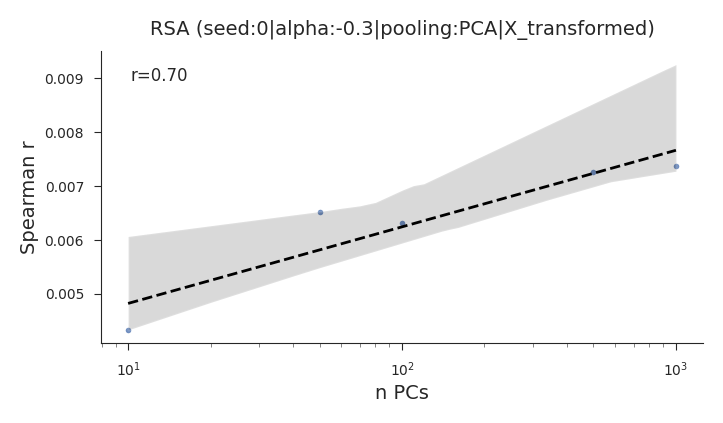

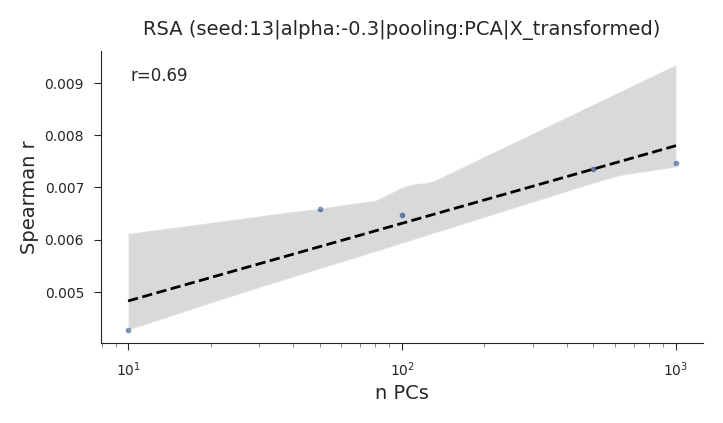

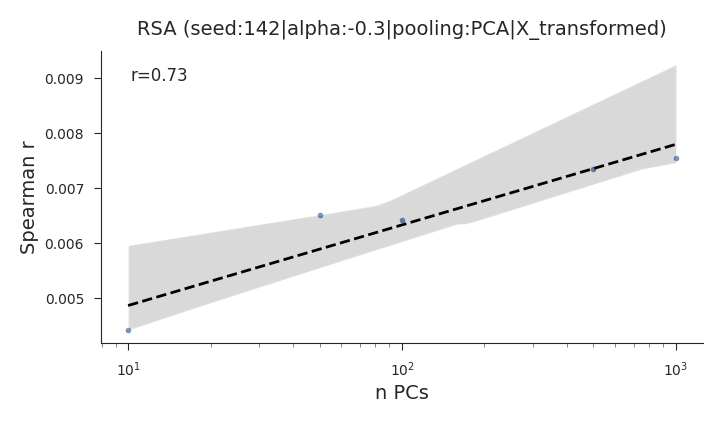

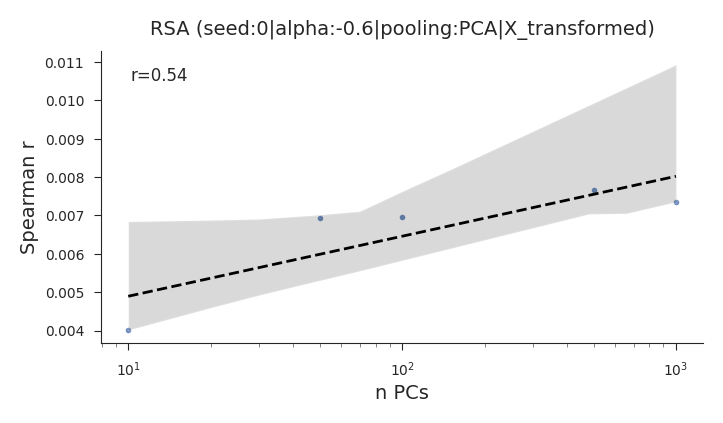

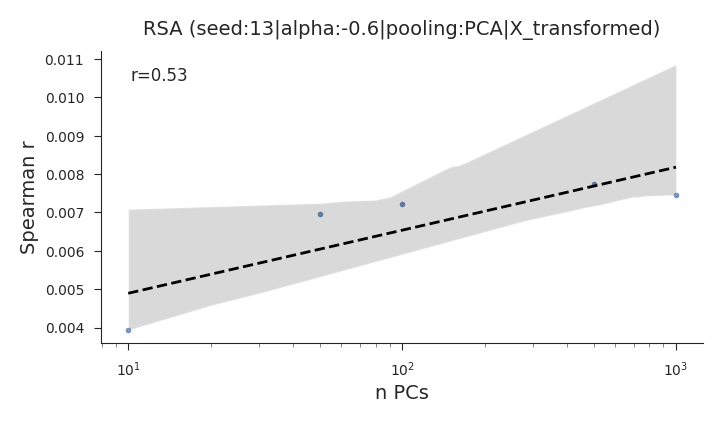

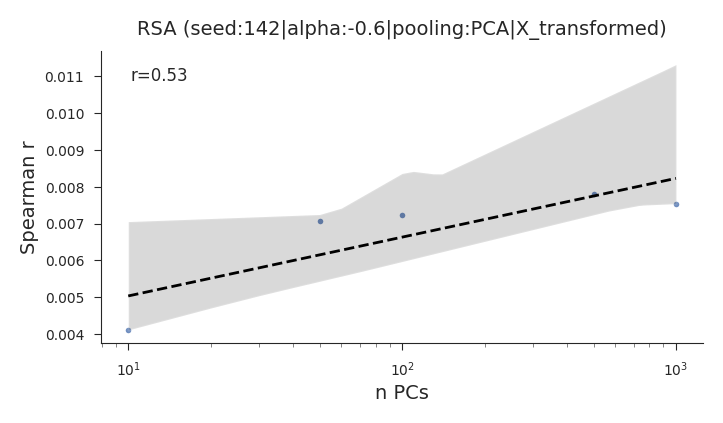

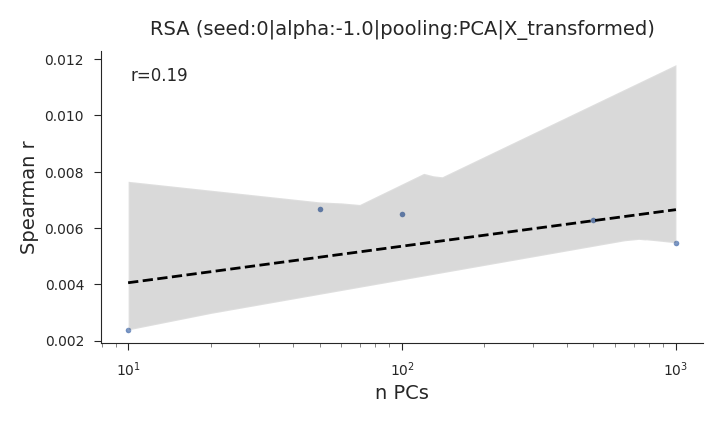

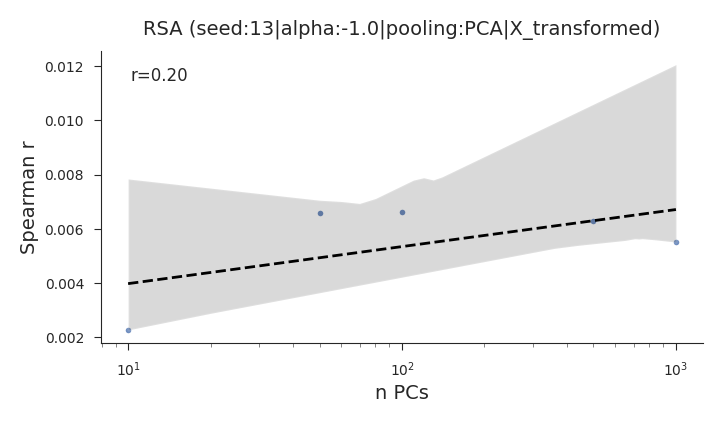

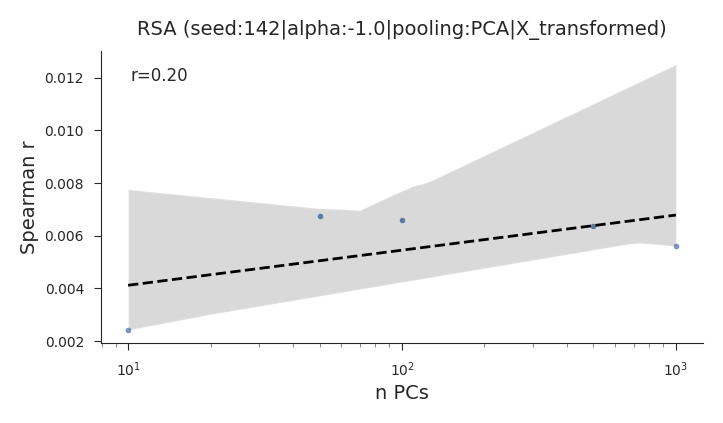

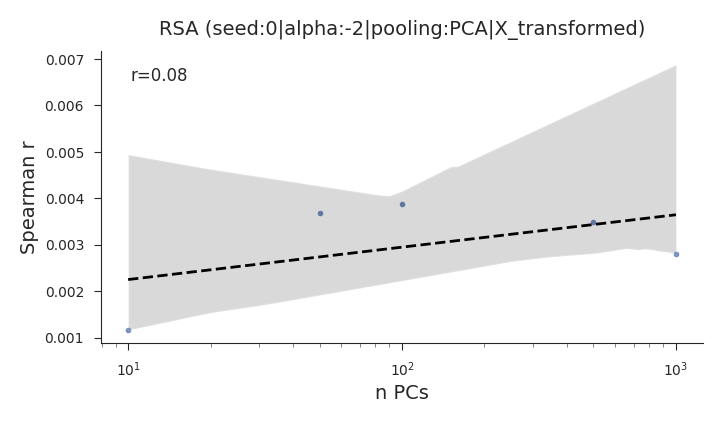

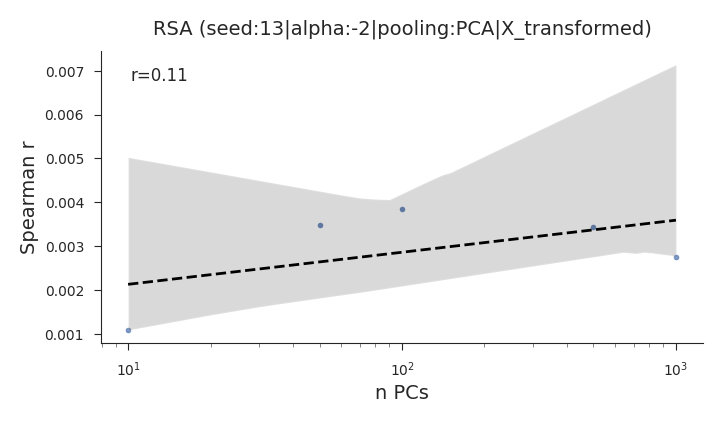

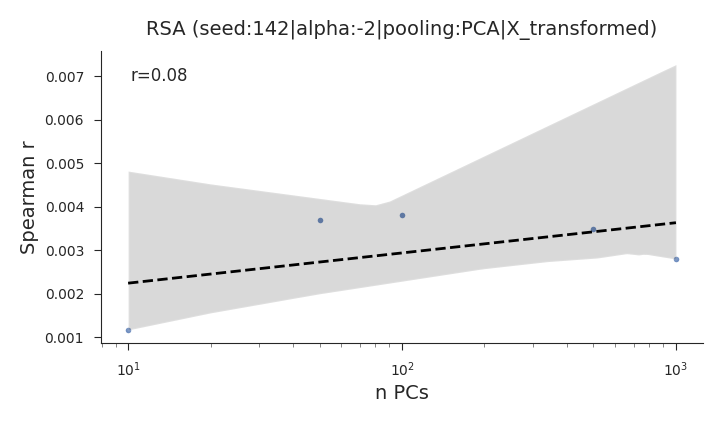

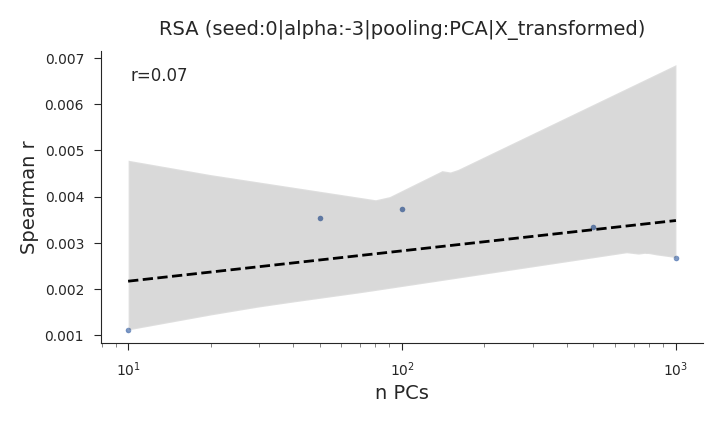

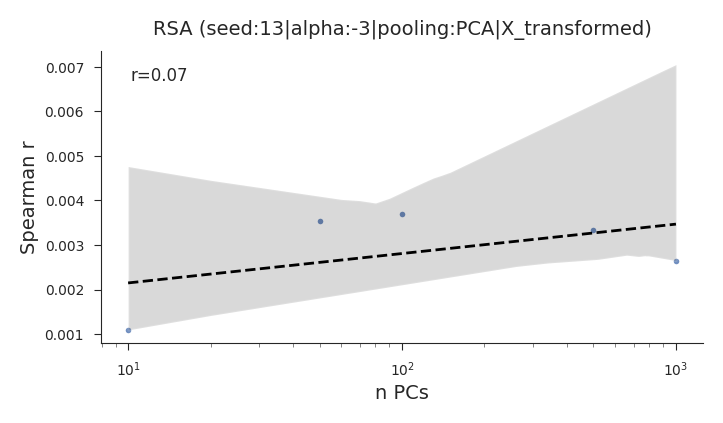

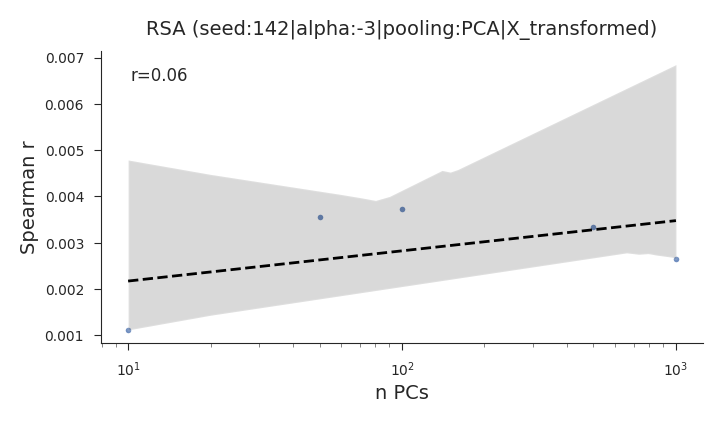

In [15]:
#RSA
# - **plot encoding score vs nPCs

seeds = [0, 13, 142]
alphas = [-0.3, -0.6, -1.0, -2, -3]

pooling = 'layerPCA'
if pooling == 'layerPCA':
    pool = 'PCA'
elif pooling == 'max_PCA':
    pooling = 'max'
#for pooling = 'max_PCA' add pooling:max to figure title
method = 'Eig'
if method == 'Eig':
    m = 'X_transformed'
elif method == 'SVD':
    m = method

#reg = 'pls'

for a in alphas:
    for seed in seeds:
        data = pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/nPCs/nPCs_seed/rsa_{method}|all_nPCs|seed:{seed}|pooling:{pooling}|benchmark:dicarlo.MajajHong2015.IT.public-rsa.csv')
        #AtlasNet,Eig_seed=0,a_-0.2,pcs_10
        data = data[ (data['layer']=='c2') ]
        data['source'] = pd.to_numeric(data['source'].str.split('_').str[1])
        data['id'] = data[id_columns].sum(axis='columns')

#alphas = [-0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0, -1.2, -1.4, -1.6, -1.8, -2, -2.2, -2.4, -2.6, -2.8, -3]

        data_alpha = data[ (data['kind']==f'a_{a}')]
        t = f'RSA (seed:{seed}|alpha:{a}|pooling:{pool}|{m})'

        r, p_val = sp.stats.pearsonr(data_alpha['source'], data_alpha['score'])

        fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))
        sns.regplot(data=data_alpha, x='source', y='score',
                    logx=True,
                    scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
                    line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
                    ax=ax)
        ax.set(xlabel='n PCs', ylabel=r'Spearman r', xscale='log', title=t)
        ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
    #ax.set_ylim(bottom=0, top=0.65)
    #ax.set_xlim(0.8, 270)

plt.show()